# Density-based Discretization Figures

Our intention is to generate figures that ilustrate how the density-based discretization algorithm works for an arbitrary density function.

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# This is our custom tesseroid code
from tesseroid_density import tesseroid

** Define arbitrary tesseroid boundaries **

In [2]:
w, e, s, n, top, bottom = -10, 10, -10, 10, 0, -35000
bounds = [w, e, s, n, top, bottom]

** Define arbitrary density function **

In [3]:
def density_function(height):
    #return height**2
    return np.exp(height*2e-4)

## Density-based discretization

First we will normalize the density function in the `[top, bottom]` interval.

In [4]:
heights = np.linspace(bottom, top, 101)
density = density_function(heights)
rho_min, rho_max = density.min(), density.max()

normal_density = (density - rho_min)/(rho_max - rho_min)

Then we will compute the line that joins the maximum and minimum points of the normalized density, the absolute difference between them and the maximum of this difference.

In [5]:
line = (normal_density[-1] - normal_density[0])/(top - bottom) * \
       (heights - bottom) + normal_density[0]

diff = np.abs(normal_density - line)

Lets compute the maximum difference and the height at which it occurs.

In [6]:
max_diff = np.max(diff)
divider_height = heights[np.argmax(diff)]

Lets plot the normalized density and the line.

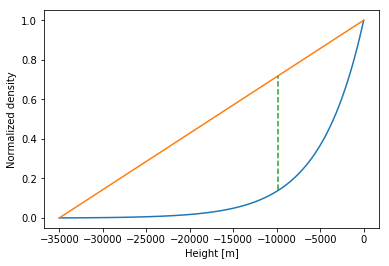

In [7]:
plt.plot(heights, normal_density)
plt.plot(heights, line)
plt.plot([divider_height]*2,
         [normal_density[np.argmax(diff)], line[np.argmax(diff)]],
         '--')
plt.xlabel("Height [m]")
plt.ylabel("Normalized density")
plt.show()

If the discretization inequality holds, then the tesseroid will be subdivided at the `divider_height`:

$$ \text{max} \{ \Delta \rho(r') \} \frac{L_r^\text{sm}}{L_r} > \delta $$

The size ratio is introduced in order to prevent the subdivisions of small tesseroids that will not significantly improve the computation accuracy but will increase the computation time.

If the tesseroid is discretized, then the same algorithm is applied for every subdivided tesseroid, althought the normalized density function is the same for every small tesseroid.

## Density-based discretization: algorithm steps

In [8]:
delta = 0.01
heights = np.linspace(bottom, top, 101)
density = density_function(heights)
rho_min, rho_max = density.min(), density.max()

def normalized_density(height):
    return (density_function(height) - rho_min)/(rho_max - rho_min)

def line(height, top, bottom):
    a = (normalized_density(top) - normalized_density(bottom))/(top - bottom)
    b = normalized_density(bottom)
    return a*(height - bottom) + b

In [9]:
delta = 1
delta_step = 0.001
max_divisions = 4
subsets = [[np.array(bounds)]]
deltas = [1]

while True:
    subset = tesseroid._density_based_discretization(bounds,
                                                     density_function,
                                                     delta)
    divisions = len(subset)
    if divisions == len(subsets[-1]) + 1:
        subsets.append(subset)
        deltas.append(delta)
    elif divisions > len(subsets[-1]) + 1:
        print("More discretizations than 1 in delta" + str(delta))
    if divisions >= max_divisions:
        break
    else:
        delta -= delta_step

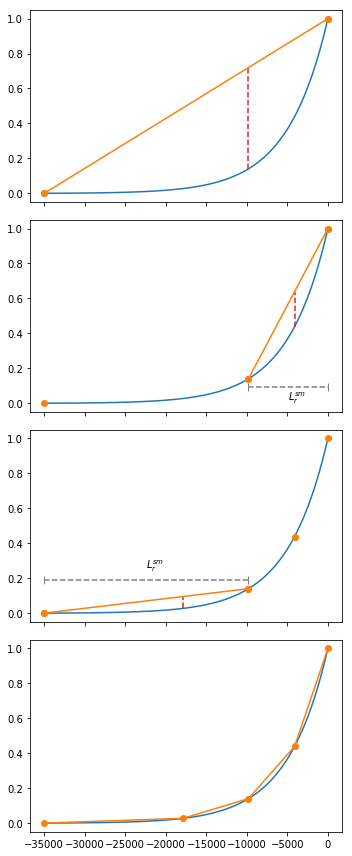

In [20]:
### heights = np.linspace(bottom, top, 101)
fig, axes = plt.subplots(len(subsets), 1,
                         sharex=True, sharey=True)
# axes = [ax for sublist in axes for ax in sublist]
fig.set_size_inches((5, 12))
divisions = np.array([top, bottom])

for i in range(len(subsets) - 1):
    ax = axes[i]
    subset = subsets[i]
    
    tops = [tess[-2] for tess in subset]
    bottoms = [tess[-1] for tess in subset]
    divisions = np.unique(np.array(tops + bottoms))
    
    tops = [tess[-2] for tess in subsets[i + 1]]
    bottoms = [tess[-1] for tess in subsets[i + 1]]
    new_divisions = np.unique(np.array(tops + bottoms))
    
    ax.plot(heights, normalized_density(heights))
    ax.plot(divisions, normalized_density(divisions), 'o')
    for j in range(1, len(new_divisions) - 1):
        bottom_j = new_divisions[j - 1]
        top_j = new_divisions[j + 1]
        div = new_divisions[j]
        if div not in divisions:
            ax.plot([div]*2,
                    [normalized_density(div),
                     line(div, top_j, bottom_j)],
                    '--', color="C3")
            ax.plot([bottom_j, top_j],
                    [normalized_density(bottom_j),
                     normalized_density(top_j)],
                    'o-', color="C1")
            if i == 1:
                ax.plot([bottom_j, top_j],
                        [normalized_density(bottom_j) - 0.05]*2, "|--",
                        color="C7", markersize=8)
                ax.annotate('$L_r^{sm}$',
                            xy=(0.5*(bottom_j + top_j),
                                normalized_density(bottom_j) - 0.1),
                            xytext=(0.5*(bottom_j + top_j),
                                    normalized_density(bottom_j) - 0.12),
                            xycoords="data")
            elif i == 2:
                ax.plot([bottom_j, top_j],
                        [normalized_density(top_j) + 0.05]*2, "|--",
                        color="C7", markersize=8)
                ax.annotate('$L_r^{sm}$',
                            xy=(0.5*(bottom_j + top_j),
                                normalized_density(top_j) + 0.12),
                            xytext=(0.5*(bottom_j + top_j),
                                    normalized_density(top_j) + 0.12),
                            xycoords="data")
                
                rectangle = Rectangle((bottom_j, -0.1),
                                      top_j - bottom_j,
                                      1.2, color="C7", alpha=0.3,
                                      linewidth=0)
                # ax.add_patch(rectangle)

ax = axes[-1]
tops = [tess[-2] for tess in subsets[-1]]
bottoms = [tess[-1] for tess in subsets[-1]]
divisions = np.unique(np.array(tops + bottoms))
ax.plot(heights, normalized_density(heights))
ax.plot(divisions, normalized_density(divisions), 'o-')

plt.tight_layout()
plt.show()

## Number of discretizations vs $\delta$

Lets execute the density-based discretization algorithm over the previously defined density function for different values of $\delta$, and plot the results.

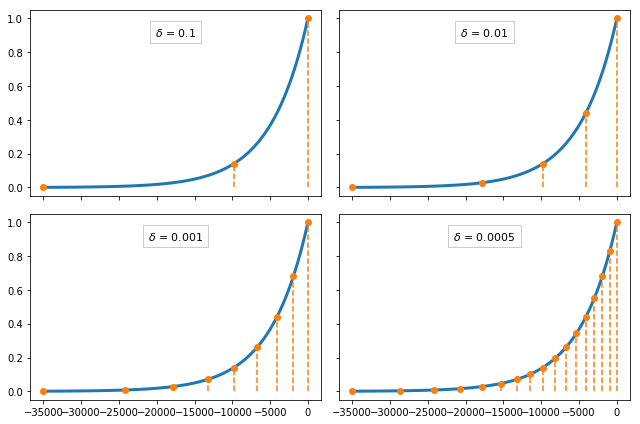

In [11]:
heights = np.linspace(bottom, top, 101)
densities = density_function(heights)
delta_values = [0.1, 0.01, 0.001, 0.0005]

fig, axes = plt.subplots(len(delta_values)//2, 2,
                         sharex=True, sharey=True)
fig.set_size_inches((9, 6))
axes = [ax for sublist in axes for ax in sublist]

for delta, ax in zip(delta_values, axes):
    subset = tesseroid._density_based_discretization(bounds,
                                                     density_function,
                                                     delta)

    dividers = [bound[-1] for bound in subset]
    dividers.sort()
    dividers.append(top)
    dividers = np.array(dividers)
    
    ax.plot(heights, densities, linewidth=3)
    ax.plot(dividers, density_function(dividers),
            'o', linewidth=1)
    for div in dividers:
        ax.plot([div]*2, [0, density_function(div)], '--', color="C1")
    ax.text(0.5, 0.88, "$\delta$ = " + str(delta), fontsize=11,
            horizontalalignment='center',
            verticalalignment='center',
            bbox={'facecolor': 'w',
                  'edgecolor': '#9b9b9b',
                  'linewidth': 0.5, 'pad': 5},
            transform=ax.transAxes)

plt.tight_layout()
plt.show()